# Cosmic Ray Rejection
## Or, No, I Don't Want No Scrub

### Part 1: Description

As if astronomers didn't have *enough* problems in their lives, the Universe$^\mathsf{\tiny TM}$ decided that **cosmic rays** should be a thing. While this is great for a lot of reasons (and some that even astronomers care about!) it can get very annoying for CCD data.

Cosmic rays (CRs) are extremely high energy -- the highest energy CRs ($\sim 10^{29}\rm\ eV$) have enough energy to eject the average person into outer space! This means they will readily ionize the semiconductor material on a typical CCD chip, which the multiplexer will readout as a "signal". The result is that the output image will have artifacts on it -- extremely bright single pixels, or even streaks across the image, depending on the angle of incidence.

Obviously, we don't want this (unless you're weird and/or masochistic). So how do we remove cosmic rays? There are, in fact, *many* approaches to this problem (some of which I'll mention later on). However, we can achieve CR rejection very simply by taking advantage of the typical CR morphology on the CCD.

### Part 2: Morphology

I've mentioned that CRs can look like bright pixels or streaks. Typically, you'll see them as bright pixels. 

**Aside**: Bright pixels on the CCD chip may not *always* result from cosmic rays. In fact, a more common artifact is the *hot pixel*, which results from an unusually high dark current due to some contamination on the chip. The morphology will be similar, but you can distinguish them by the fact that hot pixels will be the same across exposures, while CRs usually don't impact the same area twice. Hot pixels can typically be removed by *dark subtraction*. CRs typically won't show up in your dark frame due to their transient nature.

Before we get to CR rejection, let's take a look at what one actually *looks* like:

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from os import path
from astropy.io import fits
from astropy.stats import sigma_clip
from scipy.signal import medfilt
from pylab import get_cmap, rcParams

In [4]:
# # preliminaries
filepath = '/Users/luca/Documents/GradSchool/ASTR3130_2019/Lab6/Data/'
cmap = get_cmap('bone')

rcParams['figure.figsize'] = (8, 8)
rcParams['axes.titlesize'] = 16
rcParams['axes.labelsize'] = 16
rcParams['legend.fontsize'] = 16
rcParams['xtick.labelsize'] = 14
rcParams['ytick.labelsize'] = 14

In [5]:
# # import test data
files = [path.join(filepath, 'ccd%i_m101_i_300sec.fit' % i) for i in [56, 57, 58]]
data = [fits.getdata(f) for f in files]

Text(47, 1825, 'Cosmic Ray')

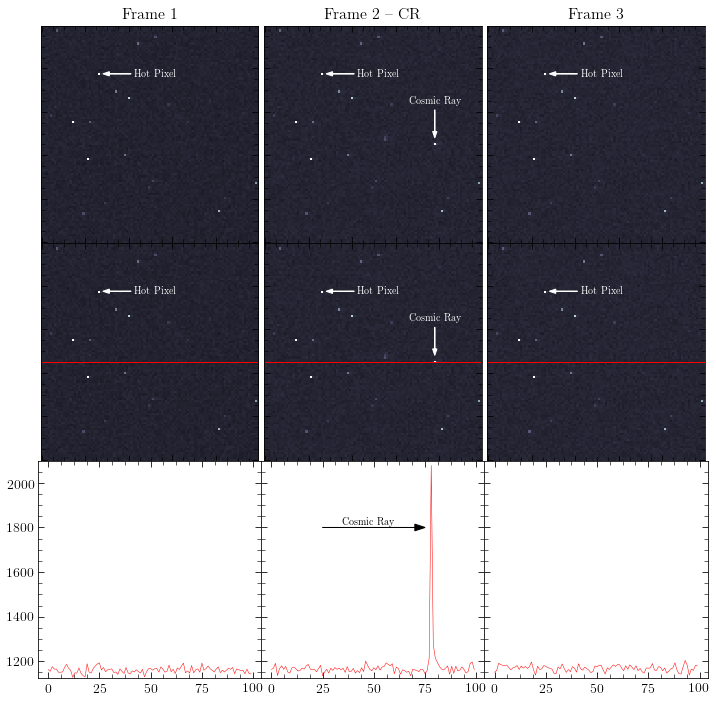

In [6]:
# # visualize CR
fig, ((ax11, ax12, ax13), (ax21, ax22, ax23), (ax31, ax32, ax33)) = plt.subplots(3, 3, figsize=(12, 12))

# label
ax11.imshow(data[0][1475:1575, 1750:1850], cmap=cmap, vmin=1000, vmax=2000)
ax11.set_title('Frame 1')
ax12.imshow(data[1][1475:1575, 1750:1850], cmap=cmap, vmin=1000, vmax=2000)
ax12.set_title('Frame 2 -- CR')
ax13.imshow(data[2][1475:1575, 1750:1850], cmap=cmap, vmin=1000, vmax=2000)
ax13.set_title('Frame 3')

for a in [ax11, ax12, ax13]:
    a.set_xticklabels([])
    a.set_yticklabels([])
    a.arrow(41, 77.5, -10, 0, color='white', head_width=2)
    a.annotate('Hot Pixel', (52, 77), color='white', va='center', ha='center')

ax12.arrow(78, 61, 0, -10, color='white', head_width=2)
ax12.annotate('Cosmic Ray', (78, 65), color='white', va='center', ha='center')

# label + slice
row = 45

ax21.imshow(data[0][1475:1575, 1750:1850], cmap=cmap, vmin=1000, vmax=2000)
ax22.imshow(data[1][1475:1575, 1750:1850], cmap=cmap, vmin=1000, vmax=2000)
ax23.imshow(data[2][1475:1575, 1750:1850], cmap=cmap, vmin=1000, vmax=2000)

for a in [ax21, ax22, ax23]:
    a.set_xticklabels([])
    a.set_yticklabels([])
    a.arrow(41, 77.5, -10, 0, color='white', head_width=2)
    a.annotate('Hot Pixel', (52, 77), color='white', va='center', ha='center')
    a.plot([0, 99], [row, row], color='red', linewidth=1)

ax22.arrow(78, 61, 0, -10, color='white', head_width=2)
ax22.annotate('Cosmic Ray', (78, 65), color='white', va='center', ha='center')

# slice
ax31.plot(data[0][1475:1575, 1750:1850][row, :], color='red', linewidth=0.5)
ax32.plot(data[1][1475:1575, 1750:1850][row, :], color='red', linewidth=0.5)
ax33.plot(data[2][1475:1575, 1750:1850][row, :], color='red', linewidth=0.5)

for a in [ax32, ax33]:
    a.set_yticklabels([])

for a in [ax31, ax32, ax33]:
    a.set_ylim(bottom=0.99 * data[1][1475:1575, 1750:1850][row, :].min(),
               top=1.01 * data[1][1475:1575, 1750:1850][row, :].max())
    
fig.subplots_adjust(wspace=0, hspace=0)

ax32.arrow(25, 1800, 45, 0, color='black', head_width=30, head_length=5)
ax32.annotate('Cosmic Ray', (47, 1825), color='black', va='center', ha='center')

### Part 3: Rejection
###### *****(wow, mood)*****

The figure above shows that cosmic rays can look similar to hot pixels, but may not show up from frame to frame. The method that I describe below *should* (in theory) work for both fairly easily -- this is helpful because you don't need to worry about the time dependence of either feature!

Ok, enough lollygaggin' -- let's get to it. We're going to implement the **median filter** technique. At each pixel in our image, it replaces the value with the median of neighboring pixels. The idea of "neighboring" is quantified by the **kernel size** (given in pixels). Typically this is given as a radius (i.e., for a kernel size $k$, it computes the median of values a radius $k$ away from the central pixel).

### NOTE: Always choose a kernel size $k \in \mathbb{O}$, where $\mathbb{O}$ denotes the set of positive odd integers.

#### 1D

Let's first look at what this means in 1D. Consider the following 1D array:

```Python
x = np.array([2, 3, 80, 7, 11])
```

In Python, the easiest way to apply a **median filter** is through scipy:

```Python
from scipy.signal import medfilt
```

If we now apply this to our array, this is the result:

```Python
medfilt(x, 3)  # choosing a kernel size of 3 pix

>>> array([ 2.,  3.,  7., 11.,  7.])
```

`medfilt` actually does this a little differently than what I just described. A kernel size of `3` computes the median of 3 values (the central pixel plus the pixels on either side). For the central value in `x`, the filter looks at the subarray `[3, 80, 7]`, which has a median value of `7`. (Side note: if we chose a kernel size of `1`, we would get back the array itself.)

Note that at the edges, `medfilt` makes a choice for you -- since the first entry doesn't have a preceding neighbor, it can't compute a median. Instead, it *pads* the array by adding zeroes on either edge. That's why the first entry returns `2` (the median of `[0, 2, 3]`) but the last entry returns `7` (the median of `[7, 11, 0]`). How to deal with edges is actually an important issue, which we won't discuss here.

#### 2D

In 2 dimensions, defining a kernel size of $k$ results in a $k \times k$ filter applied to each pixel. For `medfilt`, the zero-padding is applied again, this time in 2D.

Consider the following array:

```Python
x = np.array([[6, 90, 1], [2, 15, 0], [11, 1, 1]])
print(x)
>>> array([[ 6, 90,  1],
           [ 2, 15,  0],
           [11,  1,  1]])
```

For convenience, we've made it a $3 \times 3$ array. Let's apply a median filter with $k = 3$:

```Python
medfilt(x, 3)

>>> array([[0., 1., 0.],
           [2., 2., 1.],
           [0., 1., 0.]])
```

This is significantly different! However, it's easy to understand with just one example. For the first entry (`x[0, 0] == 6`), it creates the following subarray:

```Python
>>> array([[ 0, 0,  0],
           [ 0, 6, 90],
           [ 0, 2, 15]])
```

Notice that the bottom right entries are taken from the array itself, while the $[i,\ 0]$ and $[0,\ j]$ entries are the zeroes. `medfilt` then flattens this array and computes the median:

```Python
# flattened array
>>> array([0, 0, 0, 0, 6, 90, 0, 2, 15])
# ordered
>>> array([0, 0, 0, 0, 0, 2, 6, 15, 90])
# result
>>> 0.0
```

And so on. Of course, in 2D we're not restricted to square kernels -- we could choose an $m \times n$ kernel, where $m \neq n$. This makes things more complicated, so we won't address it here.

### Part 4: Application

Let's apply a median filter with $k = 3$ to our image from above and see the result:

In [7]:
# # apply median filter
data_filt = [medfilt(d, 3) for d in data]

Text(47, 1825, 'Cosmic Ray')

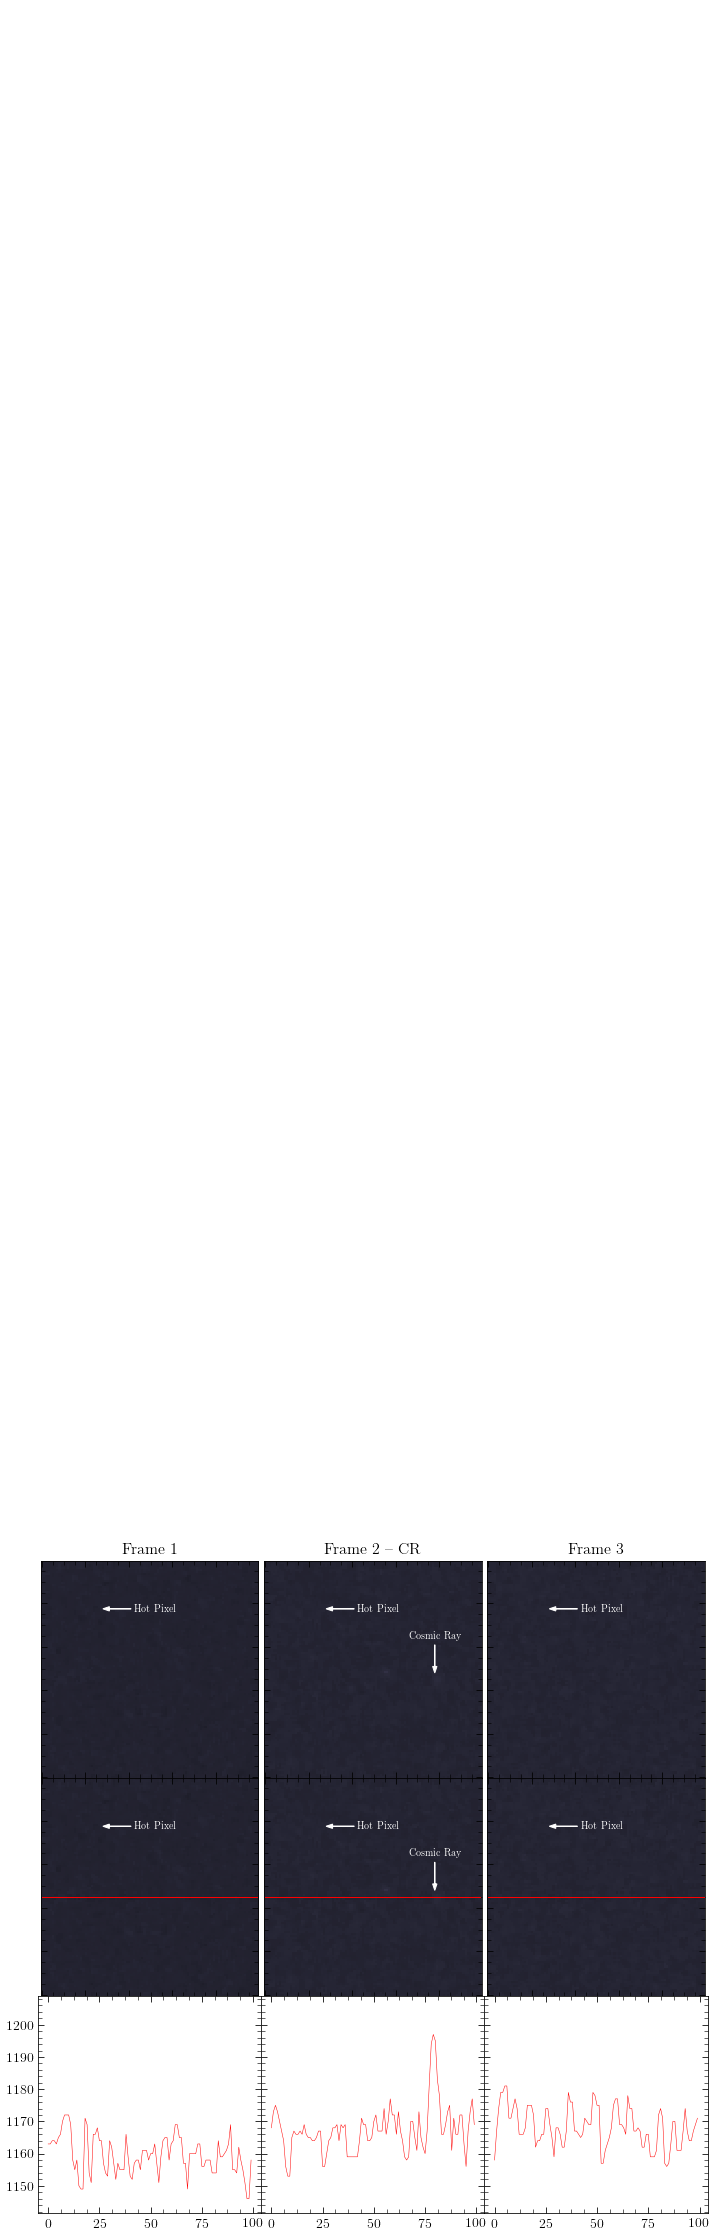

In [8]:
# # visualize filtering
fig, ((ax11, ax12, ax13), (ax21, ax22, ax23), (ax31, ax32, ax33)) = plt.subplots(3, 3, figsize=(12, 12))

# label
ax11.imshow(data_filt[0][1475:1575, 1750:1850], cmap=cmap, vmin=1000, vmax=2000)
ax11.set_title('Frame 1')
ax12.imshow(data_filt[1][1475:1575, 1750:1850], cmap=cmap, vmin=1000, vmax=2000)
ax12.set_title('Frame 2 -- CR')
ax13.imshow(data_filt[2][1475:1575, 1750:1850], cmap=cmap, vmin=1000, vmax=2000)
ax13.set_title('Frame 3')

for a in [ax11, ax12, ax13]:
    a.set_xticklabels([])
    a.set_yticklabels([])
    a.arrow(41, 77.5, -10, 0, color='white', head_width=2)
    a.annotate('Hot Pixel', (52, 77), color='white', va='center', ha='center')

ax12.arrow(78, 61, 0, -10, color='white', head_width=2)
ax12.annotate('Cosmic Ray', (78, 65), color='white', va='center', ha='center')

# label + slice
row = 45

ax21.imshow(data_filt[0][1475:1575, 1750:1850], cmap=cmap, vmin=1000, vmax=2000)
ax22.imshow(data_filt[1][1475:1575, 1750:1850], cmap=cmap, vmin=1000, vmax=2000)
ax23.imshow(data_filt[2][1475:1575, 1750:1850], cmap=cmap, vmin=1000, vmax=2000)

for a in [ax21, ax22, ax23]:
    a.set_xticklabels([])
    a.set_yticklabels([])
    a.arrow(41, 77.5, -10, 0, color='white', head_width=2)
    a.annotate('Hot Pixel', (52, 77), color='white', va='center', ha='center')
    a.plot([0, 99], [row, row], color='red', linewidth=1)

ax22.arrow(78, 61, 0, -10, color='white', head_width=2)
ax22.annotate('Cosmic Ray', (78, 65), color='white', va='center', ha='center')

# slice
ax31.plot(data_filt[0][1475:1575, 1750:1850][row, :], color='red', linewidth=0.5)
ax32.plot(data_filt[1][1475:1575, 1750:1850][row, :], color='red', linewidth=0.5)
ax33.plot(data_filt[2][1475:1575, 1750:1850][row, :], color='red', linewidth=0.5)

for a in [ax32, ax33]:
    a.set_yticklabels([])

for a in [ax31, ax32, ax33]:
    a.set_ylim(bottom=0.99 * data_filt[1][1475:1575, 1750:1850][row, :].min(),
               top=1.01 * data_filt[1][1475:1575, 1750:1850][row, :].max())
    
fig.subplots_adjust(wspace=0, hspace=0)

ax32.arrow(25, 1800, 45, 0, color='black', head_width=30, head_length=5)
ax32.annotate('Cosmic Ray', (47, 1825), color='black', va='center', ha='center')

(No idea why I'm getting such a huge whitespace here...)

The difference is striking. Notice in particular the range of count values in the bottom row of both figures.

### Part 5: TL;DR

You don't want me to talk more. Here are 2 functions that you can use to median filter your images:

In [52]:
def medfilt_array(data, kernel):
    from scipy.signal import medfilt

    if type(data) == list:  # check for list of 2D arrays
        dat = [d.copy() for d in data]
        dat_filt = [medfilt(d, kernel) for d in dat]

    else:
        dat_filt = medfilt(data, kernel)
    return dat_filt

def medfilt_fits(file, filepath, kernel, writenew=False):
    from os.path import join
    from scipy.signal import medfilt
    from astropy.io import fits

    f = join(filepath, file)
    data, header = fits.getdata(f, header=True)
    dat_filt = medfilt(data, kernel)
    if writenew:
        newfile = input('Output filename (output.fits)') or 'output.fits'
        fits.writeto(join(filepath, newfile), dat_filt, header=header, overwrite=True)
        return 'File written!'
    else:
        return dat_filt

Examples:

```Python
# first function -- single 2D array
x = np.array([[6, 90, 1], [2, 15, 0], [11, 1, 1]])
medfilt_array(x, 3)
>>> array([[0., 1., 0.],
           [2., 2., 1.],
           [0., 1., 0.]]) 
```

```Python
# first function -- list of 2D arrays
x = [np.array([[6, 90, 1], [2, 15, 0], [11, 1, 1]]) for _ in range(3)]
medfilt_array(x, 3)
>>> [array([[0., 1., 0.],
            [2., 2., 1.],
            [0., 1., 0.]]), array([[0., 1., 0.],
            [2., 2., 1.],
            [0., 1., 0.]]), array([[0., 1., 0.],
            [2., 2., 1.],
            [0., 1., 0.]])]
```

```Python
# second function -- don't write to file
x = 'test.fits'  # FITS file with data = np.array([[6, 90, 1], [2, 15, 0], [11, 1, 1]])
filepath = '/Users/'  # dummy path

medfilt_fits(x, filepath, 3, False)
>>> array([[0., 1., 0.],
           [2., 2., 1.],
           [0., 1., 0.]]) 
```

```Python
# second function -- write to file
x = 'test.fits'  # FITS file with data = np.array([[6, 90, 1], [2, 15, 0], [11, 1, 1]])
filepath = '/Users/'  # dummy path

medfilt_fits(x, filepath, 3, True)
>>> Output filename (output.fits) test.fits
>>> 'File written!'
```

### Appendix A: The Boxcar Filter

Although median filtering is very useful for removing artifacts like cosmic rays and hot pixels, it is not the only filtering technique. There are countably infinite approaches, each with their own uses, pros/cons, and implementations. Here, we'll look at just one of them.

The **boxcar function** is a function that is zero over $\mathbb{R}$ except for the interval $[a,\ b]$ where it has a constant value $A$:

Text(0, 0.5, 'Amplitude')

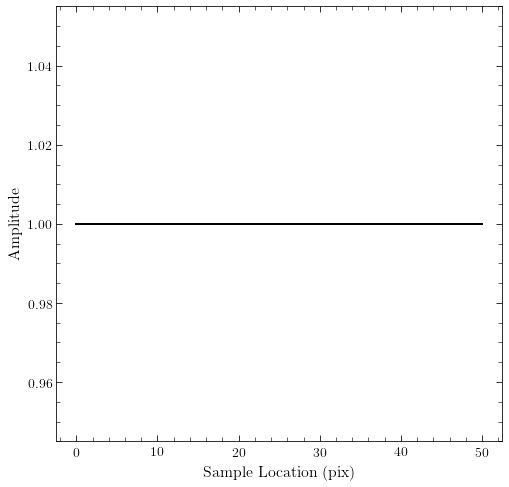

In [66]:
from scipy.signal import boxcar
fig, ax = plt.subplots()
ax.plot(boxcar(51), color='black', linewidth=2)
ax.set_xlabel('Sample Location (pix)')
ax.set_ylabel('Amplitude')

When used as a filter, the boxcar function acts like a moving average. For a kernel size of $k$, it replaces the value at pixel $i$ with the average value of the subarray $(p_{i-\lfloor k/2 \rfloor}, p_{i-\lfloor k/2 \rfloor-1}, ..., p_i, ..., p_{i+\lfloor k/2 \rfloor-1}, p_{i+\lfloor k/2 \rfloor})$. Again, let's look at examples in 1D and 2D:

#### 1D

Consider the following 1D array:

```Python
x = np.array([2, 3, 80, 7, 11])
```

In Python, the easiest way to apply a **boxcar filter** is through `astropy`:

```Python
from astropy.convolution import Box1DKernel, convolve
```

If we now apply this to our array, this is the result:

```Python
kernel = Box1DKernel(3)  # choosing a kernel size of 3 pix
convolve(x, kernel)

>>> array([ 1.66666667, 28.33333333, 30.        , 32.66666667,  6.        ])
```

The edge treatment here is basically the same as before -- for the first entry `2`, `Box1DKernel` will construct the subarray `[0, 2, 3]` and compute the average: `(0 + 2 + 3) / 3 = 1.66666667`. More generally, for kernel size $k$ at pixel position $i$, `Box1DKernel` will construct a subarray of length $k$ and compute 

$\dfrac{1}{k}\sum\limits_{j=i-\lfloor k/2 \rfloor}^{i + \lfloor k/2 \rfloor} p_j$

#### 2D

Consider the following 2D array:

```Python
x = np.array([[6, 90, 1], [2, 15, 0], [11, 1, 1]])
print(x)
>>> array([[ 6, 90,  1],
           [ 2, 15,  0],
           [11,  1,  1]])
```

This time, we need the 2D version of the boxcar filter:

```Python
from astropy.convolution import Box2DKernel
```

Again, let's apply a boxcar filter of size $k = 3$:

```Python
kernel = Box2DKernel(3)
convolve(x, kernel)

>>> array([[12.55555556, 12.66666667, 11.77777778],
           [13.88888889, 14.11111111, 12.        ],
           [ 3.22222222,  3.33333333,  1.88888889]])
```

The same logic as before applies. However, this time it averages over a $3 \times 3$ subarray. More generally, the average at pixel position $(i,\ j)$ is computed as

$\dfrac{1}{k^2}\sum\limits_{\alpha=i-\lfloor k/2 \rfloor}^{i + \lfloor k/2 \rfloor}\sum\limits_{\beta=j-\lfloor k/2 \rfloor}^{j + \lfloor k/2 \rfloor} p_{\alpha, \beta}$.

Of course, as before, we don't necessarily need a square subarray: we may choose a kernel with size $m \times n$ (where $m \neq n$) such that the average is

$\dfrac{1}{m \times n}\sum\limits_{\alpha=i-\lfloor m/2 \rfloor}^{i + \lfloor m/2 \rfloor}\sum\limits_{\beta=j-\lfloor n/2 \rfloor}^{j + \lfloor n/2 \rfloor} p_{\alpha, \beta}$.

In order to see how this differs from a median filter, let's apply a boxcar filter of kernel size $k = 3$ to our original data:

In [77]:
# # apply boxcar filter
from astropy.convolution import Box2DKernel, convolve
kernel = Box2DKernel(3)
data_box = [convolve(d, kernel) for d in data]

Text(47, 1825, 'Cosmic Ray')

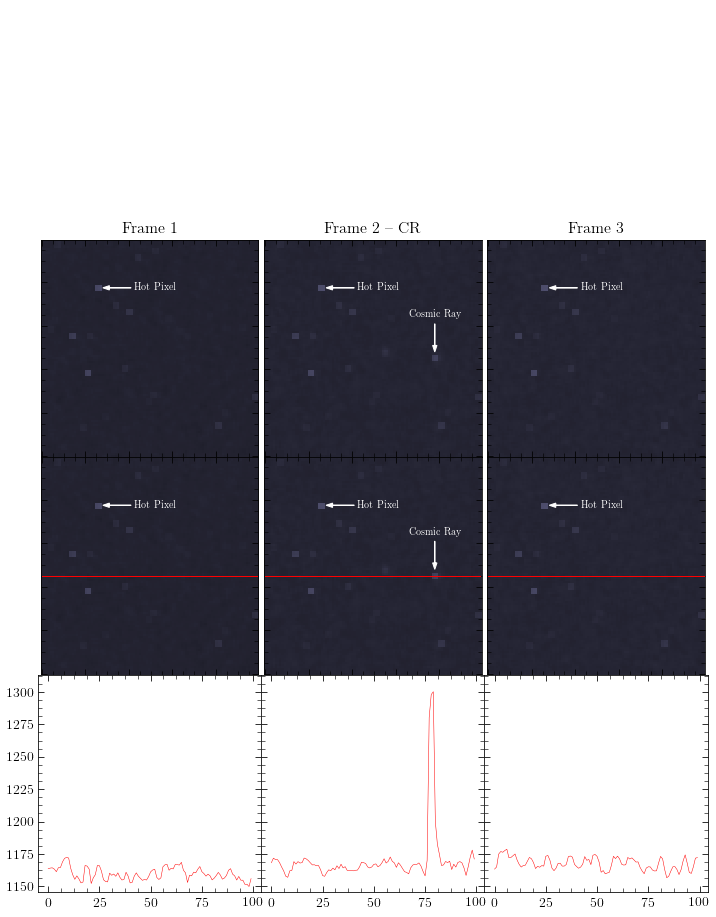

In [79]:
# # visualize filtering
fig, ((ax11, ax12, ax13), (ax21, ax22, ax23), (ax31, ax32, ax33)) = plt.subplots(3, 3, figsize=(12, 12))

# label
ax11.imshow(data_box[0][1475:1575, 1750:1850], cmap=cmap, vmin=1000, vmax=2000)
ax11.set_title('Frame 1')
ax12.imshow(data_box[1][1475:1575, 1750:1850], cmap=cmap, vmin=1000, vmax=2000)
ax12.set_title('Frame 2 -- CR')
ax13.imshow(data_box[2][1475:1575, 1750:1850], cmap=cmap, vmin=1000, vmax=2000)
ax13.set_title('Frame 3')

for a in [ax11, ax12, ax13]:
    a.set_xticklabels([])
    a.set_yticklabels([])
    a.arrow(41, 77.5, -10, 0, color='white', head_width=2)
    a.annotate('Hot Pixel', (52, 77), color='white', va='center', ha='center')

ax12.arrow(78, 61, 0, -10, color='white', head_width=2)
ax12.annotate('Cosmic Ray', (78, 65), color='white', va='center', ha='center')

# label + slice
row = 45

ax21.imshow(data_box[0][1475:1575, 1750:1850], cmap=cmap, vmin=1000, vmax=2000)
ax22.imshow(data_box[1][1475:1575, 1750:1850], cmap=cmap, vmin=1000, vmax=2000)
ax23.imshow(data_box[2][1475:1575, 1750:1850], cmap=cmap, vmin=1000, vmax=2000)

for a in [ax21, ax22, ax23]:
    a.set_xticklabels([])
    a.set_yticklabels([])
    a.arrow(41, 77.5, -10, 0, color='white', head_width=2)
    a.annotate('Hot Pixel', (52, 77), color='white', va='center', ha='center')
    a.plot([0, 99], [row, row], color='red', linewidth=1)

ax22.arrow(78, 61, 0, -10, color='white', head_width=2)
ax22.annotate('Cosmic Ray', (78, 65), color='white', va='center', ha='center')

# slice
ax31.plot(data_box[0][1475:1575, 1750:1850][row, :], color='red', linewidth=0.5)
ax32.plot(data_box[1][1475:1575, 1750:1850][row, :], color='red', linewidth=0.5)
ax33.plot(data_box[2][1475:1575, 1750:1850][row, :], color='red', linewidth=0.5)

for a in [ax32, ax33]:
    a.set_yticklabels([])

for a in [ax31, ax32, ax33]:
    a.set_ylim(bottom=0.99 * data_box[1][1475:1575, 1750:1850][row, :].min(),
               top=1.01 * data_box[1][1475:1575, 1750:1850][row, :].max())
    
fig.subplots_adjust(wspace=0, hspace=0)

ax32.arrow(25, 1800, 45, 0, color='black', head_width=30, head_length=5)
ax32.annotate('Cosmic Ray', (47, 1825), color='black', va='center', ha='center')

You'll notice that this hasn't done *as* good a job as the median filter. Additionally, it appears as if the pixels got bigger -- on closer inspection, you'll find these "pixels" are $3 \times 3$ actual pixels.

On a more positive note, this has clearly beaten down the *intensity* of the artifacts, and one may interpret the result as retaining the original characteristic of the image. This might lead us to a discussion of reasons to use the boxcar filter, but that is left for another time.

### Appendix B: TL;DR

As before, here are useful functions:

In [80]:
def boxfilt_array(data, kernel):
    from astropy.convolution import Box2DKernel, convolve
    kern = Box2DKernel(kernel)

    if type(data) == list:  # check for list of 2D arrays
        dat = [d.copy() for d in data]
        dat_filt = [convolve(d, kern) for d in dat]

    else:
        dat_filt = convolve(data, kern)
    return dat_filt

def boxfilt_fits(file, filepath, kernel, writenew=False):
    from os.path import join
    from astropy.convolution import Box2DKernel, convolve
    from astropy.io import fits
    kern = Box2DKernel(kernel)

    f = join(filepath, file)
    data, header = fits.getdata(f, header=True)
    dat_filt = convolve(data, kern)
    if writenew:
        newfile = input('Output filename (output.fits)') or 'output.fits'
        fits.writeto(join(filepath, newfile), dat_filt, header=header, overwrite=True)
        return 'File written!'
    else:
        return dat_filt

### Appendix C: References

I've alluded to the fact that there are *many* approaches to CR removal. Here's a very brief, very incomplete list:

* `crutil` in [IRAF](https://iraf.net/irafhelp.php?val=cosmicrays&help=Help+Page) : finds brightest pixels within a $k \times k$ window, computes the background-subtracted average of the neighboring pixels (excluding the second brightest pixel), computes the flux ratio `avg / brightest pixel` and replaces all pixels with a flux ratio below a user-specified threshold with that average

* `L.A. Cosmic` by [P. van Dokkum](http://www.astro.yale.edu/dokkum/lacosmic/) : convolves the image with the Laplacian of a 2D Gaussian to highlight *edges* in the signal, computes a model of the expected noise, identifies possible CRs by finding pixels where `Laplacian / Noise` is above a user-specified threshold, distinguishes CRs from point sources by their asymmetry and replaces all CR-candidate pixels with the median of surrounding pixels

* `Numpy/SciPy` implementation in [Python](http://www.ster.kuleuven.be/~pieterd/python/html/core/numpy_scipy.html#filter-cosmic-rays-from-the-background) : computes a standard deviation of the background (roughly, the above link actually uses previously known errors per pixel), subtracts a median-filtered image from the original to highlight large variations, computes the ratio `abs(Original - Medfilt) / sigma` and replaces all values greater than a user-specified threshold with the values from the median-filtered image, except for user-specified regions where real signal exists